# ASTR 596: FDS Homework 6+7: Gaussian Processes (200 pts)

### This is a double HW set so you get extra time - until reading day (May 4th, 2023) at noon to do it. 
### After that, it's finals time. 


# P1. Gaussian Processes

### Last HW, you worked on finding periodic planet signals in the light curve of Kepler-90, a star that is photometrically stable. The periodogram worked nicely because 

### a) we cleaned the light curve to squelch red noise
### b) the signals really were periodic and we could implictly make a strong assumption about the covariance between points.

### Life gets harder when the star itself has quasi-periodic variations because it has a magnetic field and is rotating (ruh oh...) 

In [45]:
%matplotlib inline

from astropy.table import Table
import scipy.stats as st
import sklearn
import sklearn.ensemble

In [46]:
tab = Table.read('KIC2157356.txt',format='ascii')
tab['quarter'] = tab['quarter'].astype('int')
tab[:10]

time,flux,error,quarter
float64,float64,float64,int32
539.4710179205795,5221.16455078125,4.891251087188721,6
539.4914521464307,5216.07958984375,4.892819404602051,6
539.5118864718097,5225.43359375,4.891888618469238,6
539.5323205971945,5233.111328125,4.892074108123779,6
539.5527548221144,5221.17333984375,4.891964435577393,6
539.573189147035,5220.09521484375,4.891523361206055,6
539.5936232714812,5222.14208984375,4.893854141235352,6
539.6140574957026,5224.57958984375,4.893648147583008,6
539.6344918194518,5223.78564453125,4.894421100616455,6


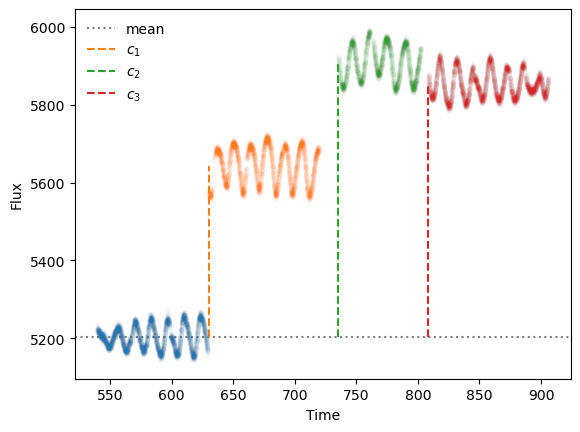

In [47]:
qs = sorted(np.unique(tab['quarter']))
plt.figure()
means = []
cycle_map = {}
for i, q in enumerate(qs):
    ind = tab['quarter']==q
    t = tab[ind]
    plt.errorbar(t['time'],t['flux'], yerr=t['error'], marker='.', linestyle='None', alpha=0.01)
    meanflux = np.mean(t['flux'])
    cycle_map[q] = ind
    means.append(meanflux)
    
    if i == 0:
        plt.axhline(meanflux, label='mean', color='grey', ls=":")
    else:

        vmin = means[0]
        vmax = meanflux

        plt.plot((t['time'][0], t['time'][0]), (vmin, vmax), label=rf'$c_{i}$', color=f'C{i}', ls='--') 
    
plt.xlabel('Time')
plt.ylabel('Flux')
plt.legend(frameon=False);


In [ ]:
means - means[0]

In [ ]:
import pandas

df = tab.to_pandas()
np.where(df['time']==np.inf)

### As you can see there is some kind of periodic singal, but it's not perfectly regular. There is also the usual offsets between Kepler photometry in different cycles.

### You'll need four parameters to describe constants ($m, c_1, c_2, c_3$) to renormalize the flux to the first cycle, illustrated in the figure above. 
### $m$ specifies the mean of the Gaussian process, while $c_1, c_2, c_3$ are nuisance parameters. 

### You know how to implement a model with one common zeropoint and multiple offsets - this was what you did on your midterm.


### You'll also need some model to describe the quasi-periodic oscillations. There's no good way to write down a model in real for these in real space because stellar magnetic fields are incredibly complicated. 

### Instead we'll write down a model for the covariance between the observations and use a Gaussian process to model the star. You can model quasi-periodic correlation structure as something periodic + something that varies the periodicity smoothly:

## $$k(t_i, t_j) = A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right) $$

### This is another 4 parameters, ($A, \Gamma_1, P, \lambda$) parameters for a total of 8: ($m, c_1, c_2, c_3, A, \Gamma_1, P, \lambda$)


<hr>

### Q1: To implement the GP correlations, use the `george` package to construct this quasi-periodic kernel
https://george.readthedocs.io/en/latest/user/kernels/


### In particular, you should be able to combine `ExpSine2Kernel` and `ExpSquaredKernel` to get a model for the quasi-periodic oscillations. (20 pts)

In [39]:
import george

$\begin{align}
k(t_i, t_j) &= A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) -  \frac{|t_i-t_j|^2}{\lambda}) \right)\\
            &= A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) \right) \cdot \exp\left(-  \frac{|t_i-t_j|^2}{\lambda}) \right) \\
\end{align}$

$A\cdot \exp\left(-\Gamma_1\cdot \sin^2\left(\frac{\pi}{P}|t_i - t_j|\right) \right) \cdot \exp\left(-  \frac{|t_i-t_j|^2}{\lambda}) \right) = A \cdot$ `ExpSine2Kernel(Gamma, P)` $\cdot$`ExpSquaredKernel(lambda)`  

In [37]:
def k(A, gamma, P, lmbda):
    
    # takes the gamma and log of period
    sin = george.kernels.ExpSine2Kernel(gamma=gamma, log_period=np.log(P))
    
    # takes just lambda
    exp2 = george.kernels.ExpSquaredKernel(metric=lmbda) # unsure about this (does metric need to be lmbda/2 for the 2 to cancel?)
    return A * george.kernels.Product(sin, exp2)

### Q2: To implement the full model, read how to use `george`'s modeling protocol: (20 pts)
https://george.readthedocs.io/en/latest/tutorials/model/

In [40]:
from george.modeling import Model
import scipy.stats as st

In [104]:
guess = [5200, 500, 700, 650, 100, 5000, 100, 300]
m = guess[0]
A = guess[4]
g = guess[5]
P = guess[6]
la = guess[7]
gp = george.GP(kernel=k(4000, 4, 4, la))

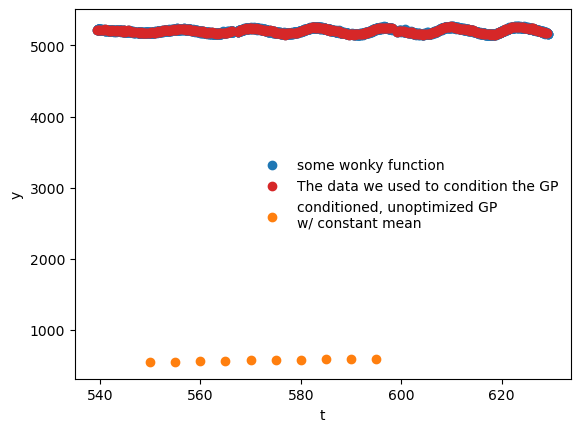

In [105]:
ind = tab['quarter']==6
t = tab[ind]
time = t['time']    
y = t['flux']
gp.compute(time[::10])

# setup a new array of times for prediction
t_new = np.arange(550, 600, 5)

plt.figure()
# now *CONDITION* the GP on the observed values y, and predict on the new values t_new
ypred1 = gp.predict(time[::10], t_new, return_cov=False)

# and plot the original data + the GP prediction with the constant mean
plt.scatter(time, y, color='C0', marker='o', label='some wonky function')
plt.scatter(time[::10], y[::10], color='C3', marker='o', label='The data we used to condition the GP')

plt.scatter(t_new, ypred1, color='C1', label='conditioned, unoptimized GP\nw/ constant mean')
plt.legend(frameon=False)
plt.xlabel('t')
plt.ylabel('y'); 

In [95]:
# m is the mean, then c is some offset from that
    # like zp and the mu from midterm
    # this will be the mean for the GP
class MeanModel(Model):
    parameter_names = ("m", "c")
    
    def get_value(self, t):
        return self.m + self.c

In [ ]:
meanmod = MeanModel(m=5200, c=200)

In [ ]:
def log_prior(p):
    p_m = st.norm.pdf(p[0], loc=5200, scale=100)
    p_c1 = st.norm.pdf(p[1], loc=500, scale=100)
    p_c2 = st.norm.pdf(p[2], loc=700, scale=100)
    p_c3 = st.norm.pdf(p[3], loc=650, scale=100)
    # do I need priors on the other things?? A, Gamma, lmda
    p_A = st.uniform.pdf(p[4], loc=10, scale=50) 
    p_Gamma = st.uniform.pdf(p[5], loc=0, scale=200)
    p_P = st.uniform.pdf(p[6], loc=50, scale=200)
    p_lambda = st.uniform.pdf(p[7], loc=100, scale=500) # cant be zero
    
    return np.log(p_m*p_c1*p_c2*p_c3*p_A*p_Gamma*p_P*p_lambda) 

In [ ]:
def log_posterior(p):
    
    # make sure that there arent any funky numbers that break george
    logP = log_prior(p) 
    if logP == -np.inf:
        return logP
    
    lnL = 0
    for i, q in enumerate(qs):
        # select the quarter
        ind = tab['quarter']==q
        t_q = tab[ind][::10] # take every 10th
                
        y = t_q['time'] 
        yerr = t_q['error']
        
        m = p[0]
        # if 0, the just mean, otherwise add the c offset
        if i ==0:
            c = 0
        else:
            c = p[i]
        
        # 4-7 = A, Gamma, P, lambda need for kernel of the gp
        gp = george.GP(kernel=k(p[4], p[5], p[6], p[7]), mean=m+c)
        gp.compute(y, yerr)
        
        # add the log likelihoods together
        lnL -= gp.log_likelihood(y, quiet=True)
    
    return lnL + logP
    
    #gp.set_parameter_vector(p[4:])
    # for each quarter
        # 
    # logL += gp.log_likelihood(y_q, quiet=True) # add the logs together
    
    # return logL

### Q3: With your model and likelihood constructured, write down priors on the parameters (you should be able to estimate from the plots) (20 pts)

I implemeted the prior above the likelihood/posterior, because otherwise the MCMC would attempt parameters that were unreasonable for the gaussian process, but I have listed here in a table the priors I considered:

$\begin{array}{c|c}
\text{Parameter} & \text{Prior} \\
\hline
m & U(5600, 200)  \\
c_1 & U(400, 200)  \\
c_2 & U(700, 200)  \\
c_3 & U(650, 200)  \\
A & U(0, 200)  \\
\Gamma_1 & U(0, 200)  \\
P & U(0, 200)  \\
\lambda & U(1, 200)  \\
\end{array}$

### Q4: Use `emcee` to optimize the model parameters and hyper-parameters, **using only every 10th sample in time**
### (Don't go overboard with the number of walkers or steps) (20 pts)
https://george.readthedocs.io/en/latest/tutorials/hyper/ may help 

In [ ]:
import emcee
import corner

In [ ]:
nwalkers = 17 # need more than 2x ndim
ndim = 8 # mean, 3 offsets, 4 kernel params
nburn = 200
nsteps = 1000
sigmas = np.ones(ndim)

guess = [5200, 500, 700, 650, 30, 0, 100, 300]
p0 = np.array(guess) + 0.1*sigmas*np.random.randn(nwalkers, ndim) # ensures no duplicate values
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)
state = sampler.run_mcmc(p0, nburn)
sampler.reset()
_ = sampler.run_mcmc(state, nsteps, progress=True); # suppress! its ugly
samples = sampler.get_chain(flat=True)

In [ ]:
fig = corner.corner(samples[::10,:], plot_countours=True, show_titles=True, smooth=2)

In [ ]:
fig = plt.figure(figsize=(12, 16))
for i in range(ndim):
    ax = fig.add_subplot(3, 4, i+1)
    ax.plot(samples[:,i])


In [ ]:
thinned_samples = samples[::10] # thin by 10
params = np.percentile(thinned_samples, 50, axis=0)
params

### Q5: Plot your posterior model over the data after correcting for the offsets, showing the points you used to condition the GP in red, and the remaining data in black.  (20 pts)

# P2. Random Forests

For this work, we'll use the datasets produced by [Dey et al. (2022)](https://ui.adsabs.harvard.edu/abs/2022MNRAS.515.5285D/abstract), who trained a deep capsule network on postage stamps of SDSS galaxies to predict photometric redshifts. 

We're not going to use a deep capsule network on postage stamps, but we can use tabular data. This won't be as performant, but it's still instructive to see how well we can do with a simple random forest. Dey et al. have done an excellent job making their data available - http://d-scholarship.pitt.edu/42023/ (all of it)

You will need the [training set](http://d-scholarship.pitt.edu/42023/9/cat_train.csv) and the [test set](http://d-scholarship.pitt.edu/42023/8/cat_test.csv).

I suggest reading through Sec. 2 of the paper to get some sense of what the data is. Importantly, the data includes columns for photometric redshift already. You can't use these to train your random forest (duh.). I've limited the number of columns you can use to a set defined below. If you use more than these (e.g. the GalaxyZoo parameters) you might get better performance at the cost of a smaller training sample because you've also got to filter missing data. 

In [1]:
train_cols = ['dered_petro_u', 'dered_petro_g', 'dered_petro_r', 'dered_petro_i', 'dered_petro_z',\
       'petroMagErr_u', 'petroMagErr_g', 'petroMagErr_r', 'petroMagErr_i', 'petroMagErr_z',\
       'v_disp', 'sersicN_r', 'petroR90_r']
pred_cols  = ['z', 'zErr', 'zphot', 'dzphot']

### Q6. Pre-process the data

All ML work involves some amount of cleaning and pre-processing the data.
Filter data that have `zphot_reliable` == `True`, and have redshifts and photo-zs >= 0. 
Next filter any entries in the `train_cols` that have any value that is > 5 $\times$ the nomrally-scaled Median Absolute Deviation (as described in Sec 2.3) (`scipy.stats.median_abs_deviation` is your friend). 
Your pre-processed training data should have 357397 entries.
Make a hexbin plot of `zphot` vs `z` for the training data (to avoid plotting that many points) but replicate Fig. 3 in Dey et al. 
(35 pts)

In [2]:
import pandas as pd
import scipy.stats as sts
import numpy as np

In [3]:
# preview the data
train_r = pd.read_csv('cat_train.csv')
test_r = pd.read_csv('cat_test.csv')

In [4]:
train=train_r[train_r['zphot_reliable']==True]
test=test_r[test_r['zphot_reliable']==True]

# when I include the last column it removes all of the things
for col in train_cols:
    train=train[train[col].notna()]
    mad_train = 5*sts.median_abs_deviation(train[col], scale='normal', axis=None)
    mean_train = np.mean(train[col])
    train=train[(train[col] - mean_train >=  -mad_train) & (train[col] - mean_train <=  mad_train)]
    
    test=test[test[col].notna()]
    mad_test = 5*sts.median_abs_deviation(test[col], scale='normal', axis=None)
    mean_test = np.mean(test[col])
    test=test[(test[col] - mean_test >=  -mad_test) & (test[col] - mean_test <=  mad_test)]
len(train)

357716

Only off by ~400 rows, so that seems reasonable

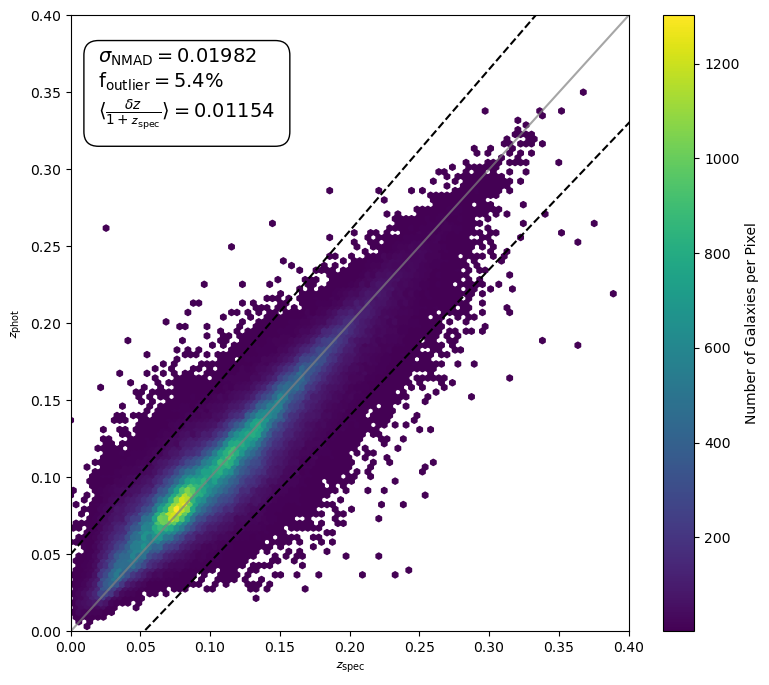

In [14]:
# format the image
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(111)
plt.rcParams["text.usetex"] == True
plt.xlabel(r'$\mathcal{z}_{\mathsf{spec}}$')
plt.ylabel(r'$\mathcal{z}_{\mathsf{phot}}$')
plt.xlim([0, 0.4])
plt.ylim([0, 0.4])

# plot the hex binned z's
plt.hexbin(train['z'], train['zphot'], mincnt=1)
plt.colorbar(label="Number of Galaxies per Pixel")

# add the lines
z = np.arange(0, 0.5, 0.05)
plt.plot(z, z, c='gray', alpha=0.7)
plt.plot(z, -0.05 + 0.95*z,'k--') # |deltaz/1 + zpec| == 0.05
plt.plot(z, 0.05 + 1.05*z,'k--')

# photo-z evalutation metrics
spec_z = train['z'].to_numpy()
phot_z = train['zphot'].to_numpy()
error = spec_z - phot_z / (1 + spec_z)
sigma = 1.4826*np.median(np.abs(error - np.median(error)))
fout = np.count_nonzero(np.abs(error) > 0.05) / len(error)

# add the text box
textstr = '\n'.join((
    r'$\sigma_{\mathrm{NMAD}}=$'+r'%.5f' % (sigma, ),
    r'$\mathrm{f}_{\mathrm{outlier}}=$' + r'%.1f'% (fout*100, ) + '%',
    r'$\langle \frac{\delta z}{1 + \mathcal{z}_{\mathsf{spec}}}\rangle = %.5f$' % (np.mean(error), )))

props = dict(boxstyle='round', facecolor='white', pad=0.75)
ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)
plt.show()

In [5]:
train.to_csv("train.csv")
test.to_csv("test.csv")

In [6]:
train = pd.read_csv("train.csv", index_col=0)
test = pd.read_csv("test.csv", index_col=0)

In [8]:
# train-test split
X_train = train[train_cols]
Y_train = train[pred_cols]
X_test = test[train_cols]
Y_test = test[pred_cols]

### Q7columnsrain the forest(s)

Using `n_estimators` (i.e. number of trees) in (5, 20, 50, 200, 500), train a random forest. You can use all the cores your CPU has with `n_jobs=-1`. Limit the maximum number of features at each branch with `sqrt`. Use the inverse variance of the redshifts as your sample weights. Plot the `oob_score` vs the number of trees. For each of the forests you trained, make a plot of the feature importances. (35 pts)

In [11]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt

In [8]:
n_trees = [5, 20, 50, 200, 500]

oobs = np.zeros(len(n_trees))
forests = pd.DataFrame(columns=train_cols, index=n_trees)

for i, n in enumerate(n_trees[:4]):

    clf = RandomForestRegressor(n_estimators=n, random_state=0, n_jobs=-1, 
                                max_features='sqrt', oob_score=True)
    
    # weight by the 1/variance of the z
    clf.fit(X_train, Y_train, sample_weight=1/Y_train['zErr']**2)
    forests.loc[n] = clf.feature_importances_
    oobs[i] = clf.oob_score_

C:\Users\Haille Perkins\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Haille Perkins\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [9]:
forests['oob'] = oobs
forests.to_csv("forests.csv")

In [ ]:
clf = RandomForestRegressor(n_estimators=400, random_state=0, n_jobs=-1, 
                                max_features='sqrt', oob_score=True)

In [36]:
forests.loc[400] = np.append(clf.feature_importances_, [clf.oob_score_, ])

In [48]:
forests = forests.drop(500) # 500 wouldnt finish (memory error), but 400 did
forests.to_csv("forests.csv")

In [31]:
forests = pd.read_csv("forests.csv", index_col=0)
forests

,dered_petro_u,dered_petro_g,dered_petro_r,dered_petro_i,dered_petro_z,petroMagErr_u,petroMagErr_g,petroMagErr_r,petroMagErr_i,petroMagErr_z,v_disp,sersicN_r,petroR90_r,oob
5,0.087966,0.186268,0.083766,0.081131,0.083357,0.030387,0.035298,0.023907,0.027405,0.030608,0.234339,0.037600,0.057968,-0.003815
20,0.099048,0.225613,0.054320,0.075612,0.060949,0.062004,0.036359,0.024572,0.027080,0.033800,0.207084,0.036279,0.057279,0.723818
50,0.119351,0.240352,0.063844,0.069995,0.050433,0.055300,0.036745,0.024576,0.026555,0.034415,0.190670,0.035259,0.052505,0.752582
200,0.134233,0.222831,0.075335,0.065869,0.046261,0.055276,0.037948,0.024868,0.026833,0.034505,0.187055,0.039315,0.049673,0.765119
400,0.132554,0.219824,0.077079,0.067008,0.047298,0.054890,0.037351,0.025027,0.026972,0.035222,0.190555,0.038860,0.047358,0.767116


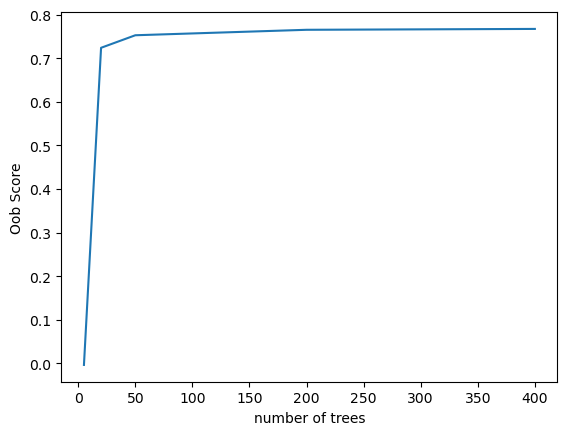

In [32]:
plt.plot(forests.index, forests['oob'])
plt.xlabel('number of trees')
plt.ylabel('Oob Score')
plt.show()

In [33]:
forests['oob']

5     -0.003815
20     0.723818
50     0.752582
200    0.765119
400    0.767116
Name: oob, dtype: float64

The largest magnitude oob score is the forest with 200 trees (400 is close but not enough for the runtime to be worth it).

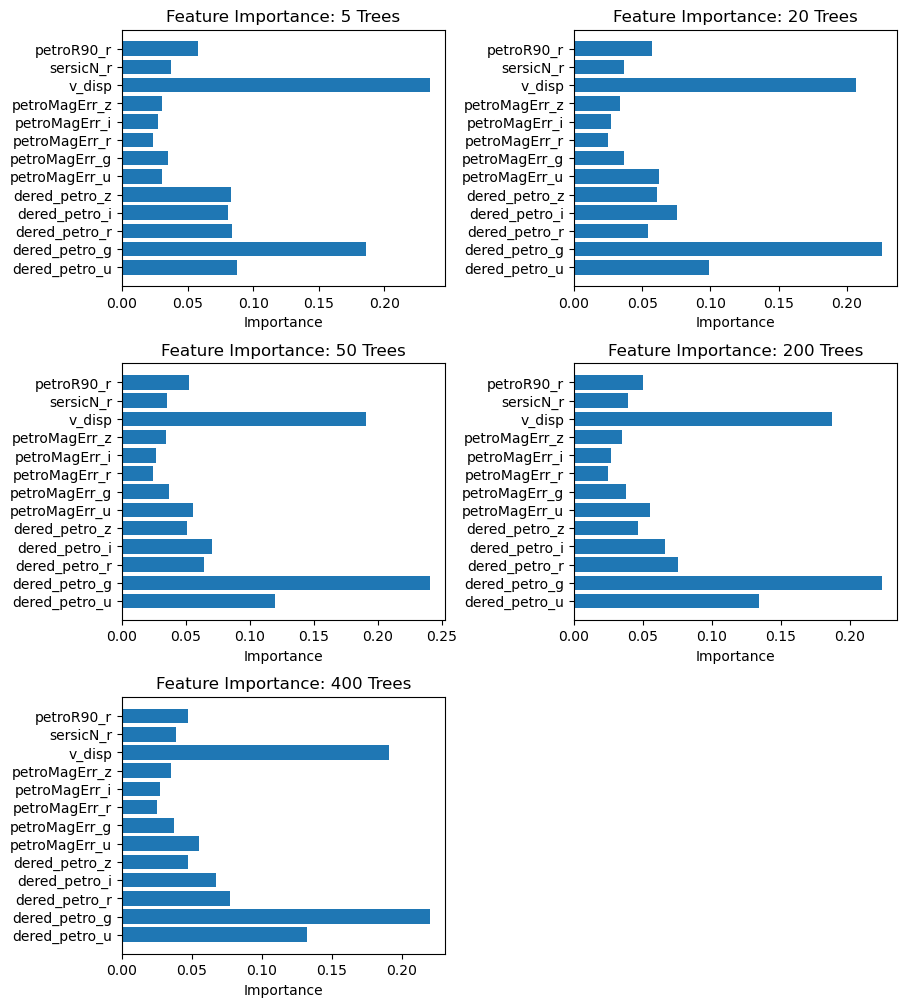

In [51]:
fig = plt.figure(figsize=(10, 12))

features = forests.columns[:-1] # added oobs, dont want that here
for i, n in enumerate(forests.index): 
    ax = fig.add_subplot(3, 2, i+1)
    ax.barh(features, forests.loc[n][:-1], align='center')
    ax.set_title(f'Feature Importance: {n} Trees')
    ax.set_xlabel("Importance")
    
plt.subplots_adjust(wspace=0.4, hspace=0.3) # avoid labels overlapping with left plots
plt.show()

As with the oob scores, 200 and 500 trees did not change the results very much. All the forests find the re-reddened petrosian i-band magnitudes to quite important. It seems more important to the smaller forests, but still have a height comparable to the more important features in the larger forests. In the forest with the similar oob scores, they find that the error in the petrosian z-band magnitude to be significant.  

### Q8. Test.

Pick your best performing forest from Q7. Load the test data (remember to apply any cuts you did to the training data). Use your random forest to predict the photo-z. Replicate Fig. 3 and Fig. 4 with your photo-z prediction *and* the photo-z prediction from SDSS included in the file. (30 pts, 10 pts for prediction, 10 for the two figures)

In [12]:
# the test data was already cut like the training data above
    # hoping that the same state ensures that this is the same one
clf = RandomForestRegressor(n_estimators=200, random_state=0, n_jobs=-1, 
                                max_features='sqrt', oob_score=True)
clf.fit(X_train, Y_train, sample_weight=1/Y_train['zErr']**2)

RandomForestRegressor(max_features='sqrt', n_estimators=200, n_jobs=-1,
                      oob_score=True, random_state=0)

In [13]:
pred = pd.DataFrame(clf.predict(X_test), columns=pred_cols)
pred

,z,zErr,zphot,dzphot
0,0.232102,0.000047,0.230598,0.014577
1,0.085183,0.000016,0.076917,0.016611
2,0.046879,0.000012,0.052319,0.010806
3,0.145908,0.000031,0.146935,0.013814
4,0.148352,0.000019,0.138359,0.026281
...,...,...,...,...
44737,0.114676,0.000026,0.121745,0.013236
44738,0.071761,0.000008,0.073261,0.016837
44739,0.098523,0.000012,0.103459,0.022321
44740,0.140576,0.000026,0.136905,0.007915


Text(0.05, 0.95, '$\\sigma_{\\mathrm{NMAD}}=$0.01331\n$\\mathrm{f}_{\\mathrm{outlier}}=$0.7%\n$\\langle \\frac{\\Delta z}{1 + \\mathcal{z}_{\\mathsf{spec}}}\\rangle = 0.01186$')

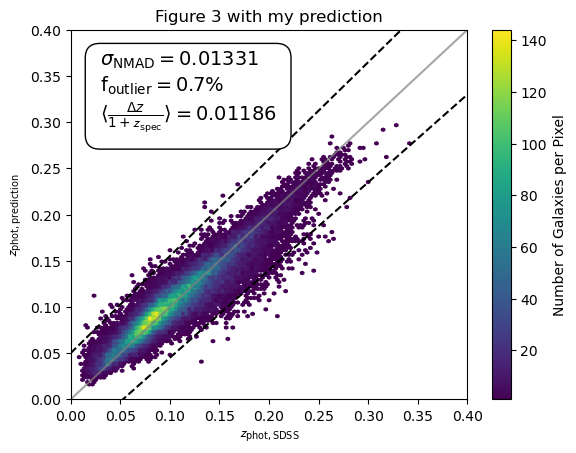

In [29]:
plt.xlabel(r'$\mathcal{z}_{\mathsf{phot, SDSS}}$')
plt.ylabel(r'$\mathcal{z}_{\mathsf{phot, prediction}}$')
plt.title('Figure 3 with my prediction')
plt.xlim([0, 0.4])
plt.ylim([0, 0.4])

# plot the hex binned z's
    # my prediction vs sdss prediction
plt.hexbin(Y_test['zphot'], pred['zphot'], mincnt=1, linewidth=(1,))
plt.colorbar(label="Number of Galaxies per Pixel")

# add the lines
z = np.arange(0, 0.5, 0.05)
plt.plot(z, z, c='gray', alpha=0.7)
plt.plot(z, -0.05 + 0.95*z,'k--') # |deltaz/1 + zspec| == 0.05
plt.plot(z, 0.05 + 1.05*z,'k--')  # deltaz = phot - spec

# photo-z evalutation metrics
test_z = Y_test['zphot'].to_numpy()
pred_z = pred['zphot'].to_numpy()
error = pred_z - test_z / (1 + test_z)
sigma = 1.4826*np.median(np.abs(error - np.median(error)))
fout = np.count_nonzero(np.abs(error) > 0.05) / len(error)

# add the text box
textstr = '\n'.join((
    r'$\sigma_{\mathrm{NMAD}}=$'+r'%.5f' % (sigma, ),
    r'$\mathrm{f}_{\mathrm{outlier}}=$' + r'%.1f'% (fout*100, ) + '%',
    r'$\langle \frac{\Delta z}{1 + \mathcal{z}_{\mathsf{spec}}}\rangle = %.5f$' % (np.mean(error), )))
props = dict(boxstyle='round', facecolor='white', pad=0.75)
plt.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)

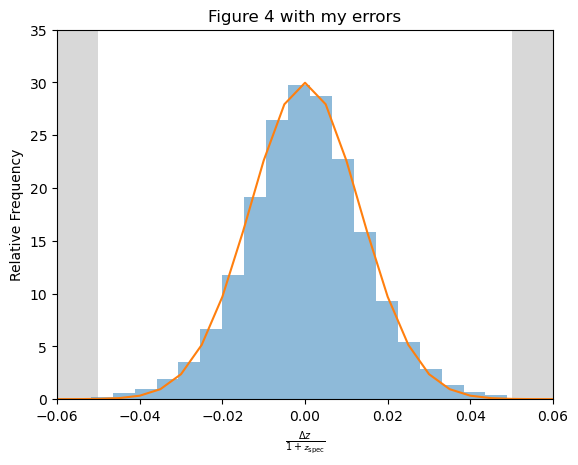

In [30]:
# making figure 4
error_norm = error - np.mean(error)
plt.hist(error_norm, bins=33, alpha=0.5, density=True) # counted 32 bins in the image

zs = np.arange(-0.15, 0.15, 0.005)
plt.plot(zs, sts.norm.pdf(zs, loc=np.mean(error_norm), scale=sigma))

plt.fill_between((-0.15, -0.05), y1=35, color='gray', alpha=0.3,linewidth=0)
plt.fill_between((0.05, 0.15), y1=35, color='gray', alpha=0.3,linewidth=0)

plt.xlim([-0.06, 0.06])
plt.ylim([0, 35])
plt.xlabel(r'$\frac{\Delta z}{1 + \mathcal{z}_{\mathsf{spec}}}$')
plt.ylabel('Relative Frequency')
plt.title('Figure 4 with my errors')
plt.show()

Histogram fits the gaussian and within the gray boundaries like Figure 4.